# Wi-Fi Network Security Threat Detection Using Machine Learning

In [1]:
# Define the path to the pcap files and the output directory
pcap_directory = "../datasets/wifi"
output_directory = "./model_output/wifi"
synthetic_dataset_path = "../data-processing/synthetic_ardupilot_wifi_data.csv"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scapy.utils import rdpcap
from scapy.layers.inet import IP
import joblib
import warnings
from datetime import datetime
import os
from scipy import stats

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, precision_recall_curve,
                           average_precision_score, confusion_matrix,
                           roc_curve, auc, silhouette_score)
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

from keras.models import load_model

warnings.filterwarnings('ignore')

2024-12-01 23:23:40.675424: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-01 23:23:41.833553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733124222.259035   28286 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733124222.375288   28286 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 23:23:43.443407: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Load Model and Scaler

In [3]:
def load_saved_models(output_directory):
    """Load all saved models and scaler"""
    # Load scaler and models
    scaler = joblib.load(os.path.join(output_directory, 'scaler.joblib'))
    iso_forest = joblib.load(os.path.join(output_directory, 'iso_forest_model.pkl'))
    lof = joblib.load(os.path.join(output_directory, 'lof_model.pkl'))
    autoencoder = load_model(os.path.join(output_directory, 'autoencoder_model.keras'))
    
    return scaler, iso_forest, lof, autoencoder

## Cross Validation

In [4]:
# Helper plotting functions
def plot_roc_curve(y_true, scores, title):
    fpr, tpr, _ = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [5]:
def extract_network_features(df):
    """
    Extract network features to match the trained models' expectations.
    Returns features DataFrame with labels included.
    """
    # Create time index
    df['datetime'] = pd.to_datetime(df['frame.time_epoch'], unit='s')

    # Ensure label column exists and fill NaN with 0
    if 'label' not in df.columns:
        df['label'] = 0
    df['label'] = df['label'].fillna(0)

    # Set datetime as index for resampling
    df.set_index('datetime', inplace=True)

    try:
        # Extract features including label during resampling
        features = df.resample('1Min').agg({
            'frame.len': ['count', 'mean', 'sum'],
            'ip.src': 'nunique',
            'ip.dst': 'nunique',
            '_ws.col.protocol': 'nunique',
            'label': 'max',  # Include label aggregation
        })

        # Flatten column names
        features.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in features.columns.values]

        # Rename 'label_max' to 'label'
        if 'label_max' in features.columns:
            features.rename(columns={'label_max': 'label'}, inplace=True)

        # Add time window index to features
        features['time_window'] = features.index

    except Exception as e:
        print(f"Error during feature extraction: {str(e)}")
        raise

    return features
def evaluate_models_on_synthetic(synthetic_df, output_directory):
    """
    Evaluate saved models using synthetic data with known labels.
    """
    print("Loading models...")
    scaler, iso_forest, lof, autoencoder = load_saved_models(output_directory)

    print("Extracting features...")
    try:
        # Extract features with labels included
        features_df = extract_network_features(synthetic_df)

        # Extract labels
        labels = features_df['label'].values.astype(int)

        # Remove label and time_window columns from features
        features_df = features_df.drop(columns=['label', 'time_window'])

        # Get expected feature names from scaler
        expected_features = scaler.feature_names_in_

        # Ensure all expected features exist
        for feature in expected_features:
            if feature not in features_df.columns:
                features_df[feature] = 0

        # Reorder columns to match scaler
        features_df = features_df[expected_features]

        # Handle any missing or infinite values
        features_df.replace([np.inf, -np.inf], np.nan, inplace=True)
        features_df.fillna(0, inplace=True)

        # Scale features
        X_scaled = scaler.transform(features_df)

        print(f"Features shape: {X_scaled.shape}")
        print(f"Labels shape: {labels.shape}")

    except Exception as e:
        print(f"Error in preprocessing: {str(e)}")
        return

    results = {}
    models = {
        'Isolation Forest': iso_forest,
        'LOF': lof,
        'Autoencoder': autoencoder
    }

    for name, model in models.items():
        print(f"\nEvaluating {name}...")
        try:
            if name == 'Autoencoder':
                reconstructed = model.predict(X_scaled)
                scores = np.mean(np.power(X_scaled - reconstructed, 2), axis=1)
            else:
                scores = -model.decision_function(X_scaled)

            y_true = labels
            threshold = np.percentile(scores, 95)
            y_pred = (scores >= threshold).astype(int)

            metrics = {
                'Accuracy': accuracy_score(y_true, y_pred),
                'Precision': precision_score(y_true, y_pred, zero_division=0),
                'Recall': recall_score(y_true, y_pred, zero_division=0),
                'F1': f1_score(y_true, y_pred, zero_division=0),
                'ROC AUC': roc_auc_score(y_true, scores)
            }

            print("\nMetrics:")
            for metric_name, value in metrics.items():
                print(f"{metric_name}: {value:.4f}")

            plot_roc_curve(y_true, scores, name)
            plot_confusion_matrix(y_true, y_pred, name)

            results[name] = metrics

        except Exception as e:
            print(f"Error evaluating {name}: {str(e)}")
            continue

    return results


In [6]:
synthetic_df = pd.read_csv(synthetic_dataset_path)

synthetic_df.columns

Index(['frame.len', 'frame.protocols', '_ws.col.protocol', 'wlan.fc.type',
       'wlan.fc.subtype', 'wlan.sa', 'wlan.da', 'wlan.bssid',
       'radiotap.channel.freq', 'radiotap.dbm_antsignal', 'radiotap.datarate',
       'frame.time_epoch', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport',
       'tcp.flags', 'tcp.len', 'tcp.stream', 'tcp.seq', 'tcp.ack',
       'udp.srcport', 'udp.dstport', 'udp.length', 'label'],
      dtype='object')

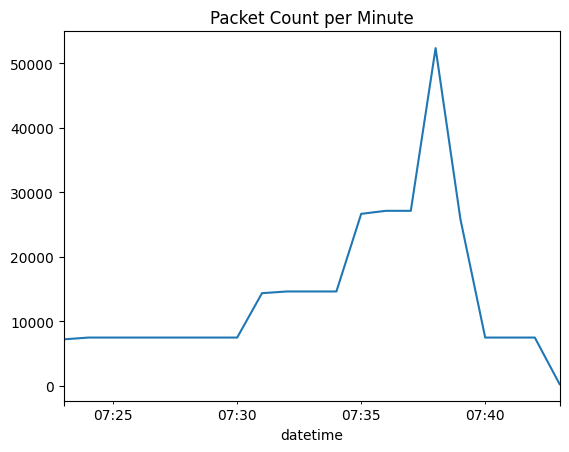

In [7]:
from matplotlib import pyplot as plt

synthetic_df['datetime'] = pd.to_datetime(synthetic_df['frame.time_epoch'], unit='s')
synthetic_df.set_index('datetime', inplace=True)


# Plot the packet count per minute
synthetic_df['frame.len'].resample('1Min').count().plot(title='Packet Count per Minute')
plt.show()

Loading models...


W0000 00:00:1733124238.805563   28286 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Extracting features...
Features shape: (21, 403)
Labels shape: (21,)

Evaluating Isolation Forest...

Metrics:
Accuracy: 0.6667
Precision: 1.0000
Recall: 0.2222
F1: 0.3636
ROC AUC: 1.0000


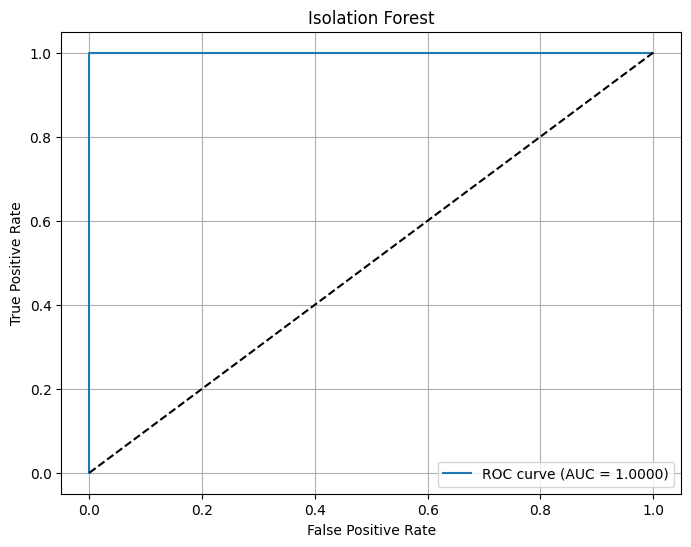

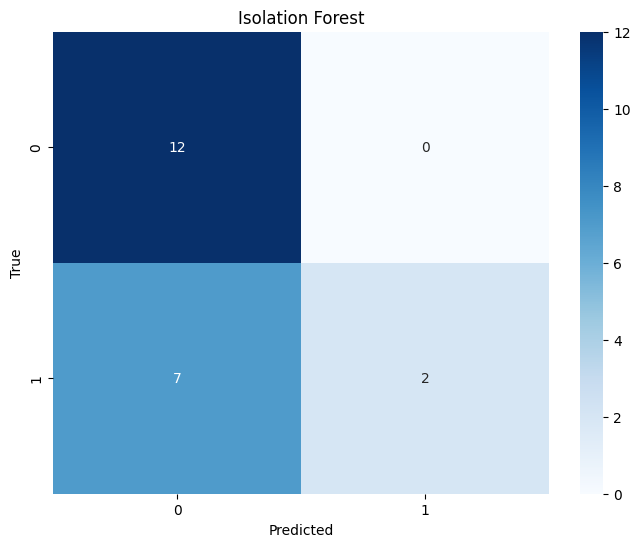


Evaluating LOF...

Metrics:
Accuracy: 0.5714
Precision: 0.5000
Recall: 0.1111
F1: 0.1818
ROC AUC: 0.4630


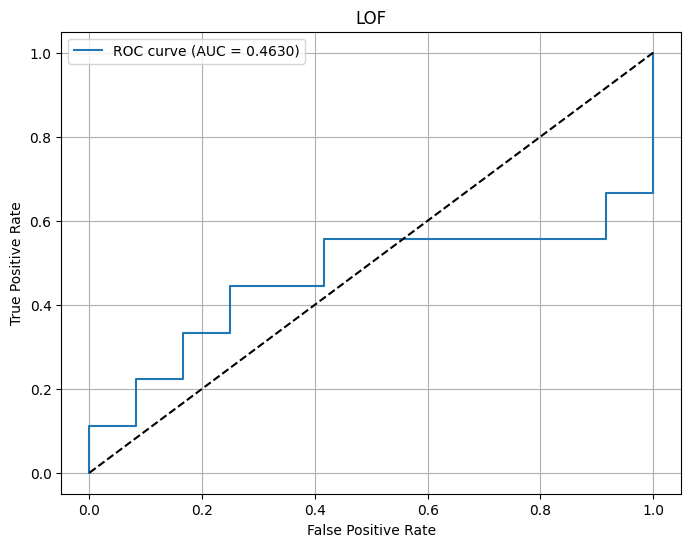

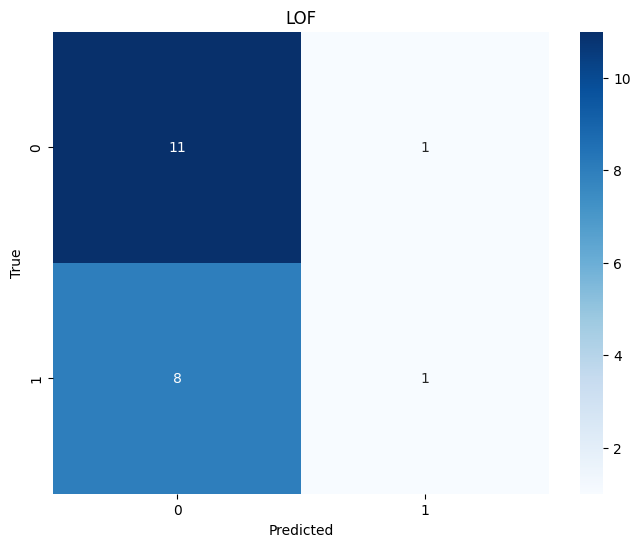


Evaluating Autoencoder...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step

Metrics:
Accuracy: 0.6667
Precision: 1.0000
Recall: 0.2222
F1: 0.3636
ROC AUC: 1.0000


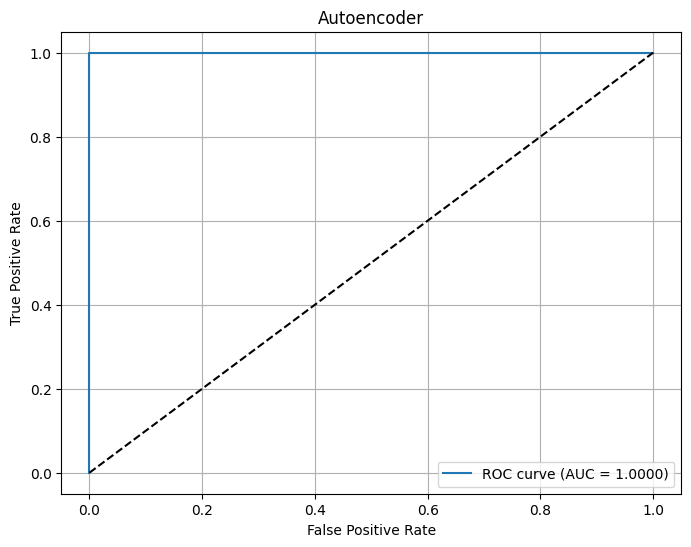

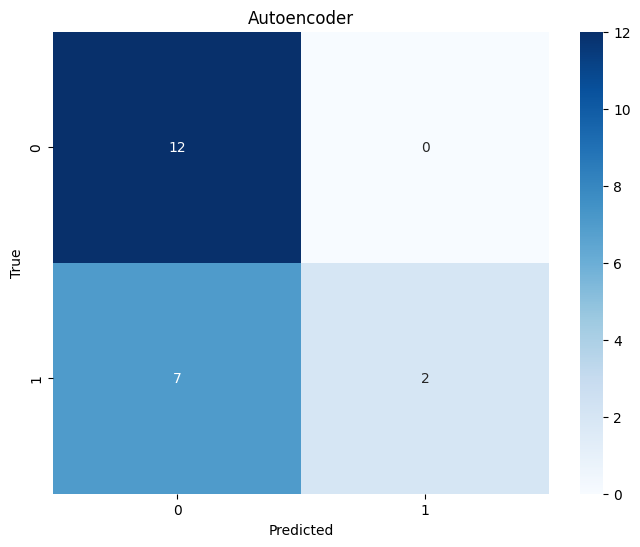


Final Evaluation Results:

Model: Isolation Forest
Accuracy: 0.6667
Precision: 1.0000
Recall: 0.2222
F1: 0.3636
ROC AUC: 1.0000

Model: LOF
Accuracy: 0.5714
Precision: 0.5000
Recall: 0.1111
F1: 0.1818
ROC AUC: 0.4630

Model: Autoencoder
Accuracy: 0.6667
Precision: 1.0000
Recall: 0.2222
F1: 0.3636
ROC AUC: 1.0000


In [8]:
results = evaluate_models_on_synthetic(synthetic_df, output_directory)

# Print final results
print("\nFinal Evaluation Results:")
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")